In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 42 # worked best for gpu
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# This is needed for CUDA (GPU) if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

url = 'https://raw.githubusercontent.com/bluefinhop/miceandcnn/main/DATA_dp_wc_bc.csv'
df1 = pd.read_csv(url)

i = 1
while i < 3:
    df1.drop(columns=df1.columns[0], axis=1, inplace=True)
    i += 1

df3 = df1.loc[df1['Tissue'] == 'preparation']
df4 = df1.loc[df1['Tissue'] == 'biopsy']

one_hot_df3 = pd.get_dummies(df3['Annotation'])
one_hot_df4 = pd.get_dummies(df4['Annotation'])

arrdf3labels = one_hot_df3.iloc[:, :4].to_numpy()
arrdf4labels = one_hot_df4.iloc[:, :4].to_numpy()

arrdf3 = df3.iloc[:, :-2].values
arrdf4 = df4.iloc[:, :-2].values

dfTraining = pd.DataFrame({
    "pixels": arrdf3.tolist(),
    "label": arrdf3labels.tolist()
})
dfTesting = pd.DataFrame({
    "pixels": arrdf4.tolist(),
    "label": arrdf4labels.tolist()
})

seq_len = arrdf3.shape[1]
num_samples = arrdf3.shape[0]
seq_len2 = arrdf4.shape[1]
num_samples2 = arrdf4.shape[0]


class TimeSeriesDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.tensor(self.df["pixels"][idx], dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(np.argmax(self.df["label"][idx]), dtype=torch.long)
        return x.to(device), y.to(device)


train_dataset = TimeSeriesDataset(dfTraining)
test_dataset = TimeSeriesDataset(dfTesting)
frac_train = 0.85
train_dataset, val_dataset = random_split(train_dataset, [int(frac_train * len(train_dataset)), len(train_dataset) - int(frac_train * len(train_dataset))])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


class CNN(nn.Module):
    def __init__(self, num_cnn_layers, kernel_size, dropout_prob=0.5):
        super(CNN, self).__init__()
        layers = []
        in_channels = 1
        output_length = seq_len
        num_pooling_layers = 0
        for i in range(num_cnn_layers):
            out_channels = 10
            padding = (kernel_size - 1) // 2
            layers.append(nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
            layers.append(nn.BatchNorm1d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            if (i + 1) % 25 == 0:
                layers.append(nn.MaxPool1d(kernel_size=2))
                output_length //= 2
                num_pooling_layers += 1
            in_channels = out_channels
        self.cnn = nn.Sequential(*layers)

        self.fc1 = nn.Linear(in_features=out_channels * output_length, out_features=4)
        self.num_cnn_layers = num_cnn_layers
        self.kernel_size = kernel_size
        self.dropout_prob = dropout_prob

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the output of the last convolutional layer
        x = self.fc1(x)
        return x.to(device)

def train_model(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


def validate_model(model, dataloader, loss_fn):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def load_model(model_path, num_cnn_layers, kernel_size, dropout_prob):
    # Instantiate the CNN model with the desired parameters
    cnn = CNN(num_cnn_layers=num_cnn_layers, kernel_size=kernel_size, dropout_prob=dropout_prob)
    
    # Load the model's state dictionary from the saved file
    cnn.load_state_dict(torch.load(model_path))
    
    # Move the model to the appropriate device
    cnn.to(device)
    
    return cnn

def run_experiment(num_cnn_layers, kernel_size, dropout_prob, learning_rate, num_epochs, l2_lambda, model_path=None):
    # Instantiate the CNN model with the desired parameters or load from the given file
    if model_path is None:
        cnn = CNN(num_cnn_layers=num_cnn_layers, kernel_size=kernel_size, dropout_prob=dropout_prob)
    else:
        cnn = load_model(model_path, num_cnn_layers, kernel_size, dropout_prob)
    
    cnn.to(device)


    # Define the loss function and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    # Initialize lists to store the epoch data
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Train the model
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(cnn, train_loader, loss_fn, optimizer)
        val_loss, val_acc = validate_model(cnn, val_loader, loss_fn)

        # Store the epoch data in the lists
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        #print(f"Epoch {epoch + 1}/{num_epochs}:")
        #print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%")
        #print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")
        #print()

    # Evaluate the CNN model on test data
    cnn.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = cnn(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    accuracy = correct / total
    print(f"Accuracy on test data: {accuracy * 100:.2f}%")

    # Save the epoch data and final test accuracy to a CSV file
    import csv

    filename_prefix = f"cnn_layers_{cnn.num_cnn_layers}_kernel_{cnn.kernel_size}_dropout_{cnn.dropout_prob}_learning_rate_{learning_rate}_epochs_{num_epochs}_l2_lambda_{l2_lambda}"
    # Save the model
    #torch.save(cnn.state_dict(), f'{filename_prefix}_model.pth')

    with open(f'{filename_prefix}_epoch_data.csv', 'w', newline='') as csvfile:
        fieldnames = ['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(num_epochs):
            writer.writerow({'epoch': i + 1, 'train_loss': train_losses[i], 'train_acc': train_accuracies[i], 'val_loss': val_losses[i], 'val_acc': val_accuracies[i]})

    with open(f'{filename_prefix}_test_accuracy.txt', 'w') as f:
        f.write(f"Accuracy on test data: {accuracy * 100:.2f}%")

# Call the run_experiment function with your desired parameters
num_cnn_layers_values = [4] #[2, 4, 10, 25, 50, 100]
kernel_size_values = [3] #[3, 5, 7]
dropout_prob_values = [0] #[0.1, 0.3, 0.5]
learning_rate_values = [0.001] #[0.005, 0.001, 0.0005]
num_epochs_values = [10] #[10, 50, 90, 100, 150, 200]
l2_lambda_values = [0.0, 0.0001, 0.001]

for num_cnn_layers in num_cnn_layers_values:
    for kernel_size in kernel_size_values:
        for dropout_prob in dropout_prob_values:
            for learning_rate in learning_rate_values:
                for num_epochs in num_epochs_values:
                    for l2_lambda in l2_lambda_values:
                        print(f"Running experiment with num_cnn_layers={num_cnn_layers}, kernel_size={kernel_size}, dropout_prob={dropout_prob}, learning_rate={learning_rate}, num_epochs={num_epochs}, l2_lambda={l2_lambda}")
                        run_experiment(num_cnn_layers=num_cnn_layers, kernel_size=kernel_size, dropout_prob=dropout_prob, learning_rate=learning_rate, num_epochs=num_epochs, l2_lambda=l2_lambda, model_path='cnn_layers_4_kernel_3_dropout_0.1_learning_rate_0.001_epochs_10_l2_lambda_0.0_model.pth')
                        print()

Running experiment with num_cnn_layers=4, kernel_size=3, dropout_prob=0, learning_rate=0.001, num_epochs=10, l2_lambda=0.0
Accuracy on test data: 77.22%

Running experiment with num_cnn_layers=4, kernel_size=3, dropout_prob=0, learning_rate=0.001, num_epochs=10, l2_lambda=0.0001
Accuracy on test data: 73.42%

Running experiment with num_cnn_layers=4, kernel_size=3, dropout_prob=0, learning_rate=0.001, num_epochs=10, l2_lambda=0.001
Accuracy on test data: 75.95%



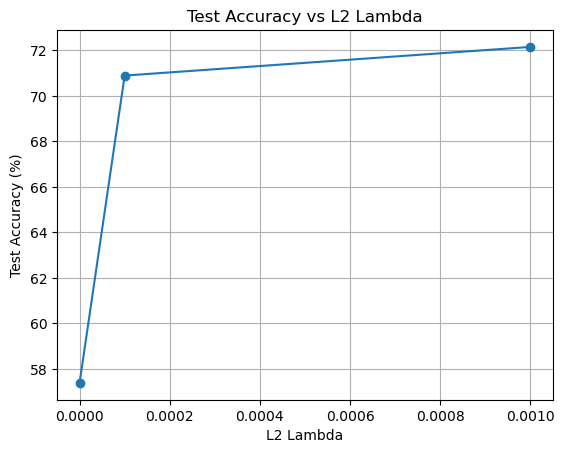

{0.0001: 70.89, 0.001: 72.15, 0.0: 57.38}


In [16]:
import os
import matplotlib.pyplot as plt

# Initialize the dictionary to store test accuracies
test_accuracies = {}

# Iterate over the files in the current directory
for file in os.listdir():
    # Check if the file is a test accuracy file and contains the '_l2_lambda_' pattern
    if file.endswith('_test_accuracy.txt') and '_l2_lambda_' in file:
        # Extract the l2_lambda value from the file name
        l2_lambda = float(file.split('_l2_lambda_')[1].split('_')[0])

        # Read the test accuracy from the file
        with open(file, 'r') as f:
            test_accuracy = float(f.readline().split(': ')[1].strip('%'))

        # Store the test accuracy in the dictionary
        test_accuracies[l2_lambda] = test_accuracy

# Sort the dictionary by l2_lambda values
sorted_test_accuracies = dict(sorted(test_accuracies.items()))

# Plot the test accuracy vs l2_lambda
plt.plot(list(sorted_test_accuracies.keys()), list(sorted_test_accuracies.values()), marker='o')
plt.xlabel('L2 Lambda')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs L2 Lambda')
plt.grid()
plt.show()
print(test_accuracies)